In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [18]:
DATA_PATH =  '../../../data/cluster/year/'
HISTORIC_DATA_PATH = '../../../data/cluster/historic/'
OPTIMAL_THRESHOLD = 0.5
[f for f in os.listdir(DATA_PATH) if 'full' in f]

['X_test_full.csv',
 'X_train_full.csv',
 'X_valid_full.csv',
 'y_test_full.csv',
 'y_train_full.csv',
 'y_valid_full.csv']

In [3]:
X_train = pd.read_csv(DATA_PATH + 'X_train_full.csv')
X_valid = pd.read_csv(DATA_PATH + 'X_valid_full.csv')
X_test  = pd.read_csv(DATA_PATH + 'X_test_full.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train_full.csv')
y_valid = pd.read_csv(DATA_PATH + 'y_valid_full.csv')
y_test  = pd.read_csv(DATA_PATH + 'y_test_full.csv')

X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_valid = X_valid.drop(['Unnamed: 0'], axis=1)
X_test  = X_test.drop(['Unnamed: 0'],  axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_valid = y_valid.drop(['Unnamed: 0'], axis=1)
y_test  = y_test.drop(['Unnamed: 0'],  axis=1)


print('train: X %s\t y%s' % (X_train.shape, y_train.shape))
print('valid: X %s\t y%s' % (X_valid.shape, y_valid.shape))
print('test:  X %s\t y%s' % (X_test.shape,  y_test.shape))

train: X (529623, 25)	 y(529623, 1)
valid: X (117694, 25)	 y(117694, 1)
test:  X (117694, 25)	 y(117694, 1)


In [4]:
X = X_train.append(X_valid).append(X_test)
y = y_train.append(y_valid).append(y_test)

In [5]:
del X_train
del X_valid
del X_test
del y_train
del y_valid
del y_test

In [6]:
util.print_percent_presence(y, 'y')

Percent presence in y: 15.90%


In [7]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  y:', 100 - 15.9)

Baseline accuracy if predicting "absent" for all cells:
  y: 84.1


In [8]:
np.isfinite(X).all()

year                        True
meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
studyArea                   True
elev_srtm30                 True
x                           True
y                           True
next_year_beetle            True
dtype: bool

In [9]:
#X_train, y_train = util.drop_nans(
#    X_train, y_train, 'varPrecip_growingSeason')
#X_valid, y_valid = util.drop_nans(
#    X_valid, y_valid, 'varPrecip_growingSeason')
#X_test,  y_test  = util.drop_nans(
#    X_test,  y_test,  'varPrecip_growingSeason')

In [10]:
full = X.copy()
full['beetle'] = y['beetle']

In [11]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X = X.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason'], 
    axis=1)

In [12]:
predictors = list(X)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'next_year_beetle']


In [13]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
y = y['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [15]:
logistic_clf = LogisticRegression(C=0.001923583801, penalty='l1')
logistic_clf.fit(X, y)

LogisticRegression(C=0.001923583801, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [16]:
coefs = pd.DataFrame(
    [[pred, coef] 
     for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
    columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
7,meanMaxTemp_Aug,1.468151
2,meanTemp_Aug,-1.122810
18,next_year_beetle,1.110392
10,vegetation,1.059739
1,meanTemp_AprAug,-0.894905
16,lat,0.566436
5,meanMinTemp_Jan,0.417170
14,precip_growingSeason,0.397025
15,elev_etopo1,0.385626
6,meanMinTemp_Mar,0.372291


In [19]:
probs = logistic_clf.predict_proba(X)
probs = [p[1] for p in probs]

X_df = pd.DataFrame(data=X, index=full.index, columns=predictors)
X_df['year'] = full['year']
X_df['x'] = full['x']
X_df['y'] = full['y']
X_df['probs'] = probs
X_df['preds'] = X_df['probs'].apply(lambda x: 1 if x >= OPTIMAL_THRESHOLD else 0)
X_df.head()

,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,precip_JunAug,...,precip_growingSeason,elev_etopo1,lat,lon,next_year_beetle,year,x,y,probs,preds
0,1.779901,1.031717,0.692064,2.156904,2.132952,2.154030,1.838071,0.234716,-0.832759,-1.524314,...,-1.130389,-1.581892,-1.878487,-0.219633,-0.437582,2004,-1550000.0,-2000000.0,0.003115,0
1,1.810399,1.070444,0.729096,2.167114,2.177756,2.168658,1.860591,0.265992,-0.850154,-1.531558,...,-1.137565,-1.632926,-1.876435,-0.205981,-0.437582,2004,-1540000.0,-2000000.0,0.003033,0
2,1.876612,1.189120,0.879578,2.144328,2.183344,2.150461,1.852764,0.465818,-0.867441,-1.516633,...,-1.144905,-1.437539,-1.874396,-0.192324,-0.437582,2004,-1530000.0,-2000000.0,0.003276,0
3,1.697914,1.018269,0.783339,1.995871,1.882680,2.000235,1.639783,0.488734,-0.769838,-1.417870,...,-1.032230,-0.928658,-1.872369,-0.178663,-0.437582,2004,-1520000.0,-2000000.0,0.004409,0
4,1.731313,1.103871,0.899678,1.957738,1.860960,1.959547,1.615586,0.658747,-0.781328,-1.397978,...,-1.048549,-0.835339,-1.870356,-0.164997,-0.437582,2004,-1510000.0,-2000000.0,0.004568,0


In [21]:
sorted(X_df.year.unique())

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]

In [22]:
out_data = X_df.loc[X_df.year == 2000, ['x', 'y', 'probs', 'preds']]
out_data = out_data.rename(columns={'probs': 'probs_2000', 'preds': 'preds_2000'})
out_data.index = out_data.apply(lambda row: str(row['x']) + str(row['y']), axis=1)

for year in range(2001, 2013):
    year_data = X_df.loc[X_df.year == year, ['x', 'y', 'probs', 'preds']]
    year_data.index = year_data.apply(lambda row: str(row['x']) + str(row['y']), axis=1)
    out_data['probs_%s' % year] = year_data['probs']
    out_data['preds_%s' % year] = year_data['preds']
out_data.index = range(out_data.shape[0])
out_data.head()

,x,y,probs_2000,preds_2000,probs_2001,preds_2001,probs_2002,preds_2002,probs_2003,preds_2003,...,probs_2008,preds_2008,probs_2009,preds_2009,probs_2010,preds_2010,probs_2011,preds_2011,probs_2012,preds_2012
0,-1550000.0,-2000000.0,0.002800,0,0.002739,0,0.003665,0,0.003280,0,...,0.003061,0,0.003196,0,0.003215,0,0.002997,0,0.002936,0
1,-1540000.0,-2000000.0,0.002710,0,0.002652,0,0.003533,0,0.003178,0,...,0.002970,0,0.003088,0,0.003094,0,0.002918,0,0.002841,0
2,-1530000.0,-2000000.0,0.002906,0,0.002849,0,0.003778,0,0.003425,0,...,0.003236,0,0.003354,0,0.003333,0,0.003181,0,0.003069,0
3,-1520000.0,-2000000.0,0.003873,0,0.003862,0,0.005155,0,0.004656,0,...,0.004464,0,0.004649,0,0.004592,0,0.004390,0,0.004223,0
4,-1510000.0,-2000000.0,0.004025,0,0.003978,0,0.005345,0,0.004849,0,...,0.004702,0,0.004883,0,0.004834,0,0.004598,0,0.004403,0


In [20]:
def get_ranges(data, verbose=False):
    xrange = data.x.min(), data.x.max()
    yrange = data.y.min(), data.y.max()
    if verbose:
        print('x range:', xrange, '\ny range:', yrange)
    return xrange, yrange

In [21]:
x_range, y_range = get_ranges(full, verbose=True)

x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


In [22]:
def mask_data(data, xrange, yrange, verbose=False):
    if verbose:
        print('Input data:')
        get_ranges(data, verbose)
    data = data.loc[(data.x >= xrange[0])
                    & (data.x <= xrange[1])
                    & (data.y >= yrange[0])
                    & (data.y <= yrange[1]), :]
    if verbose:
        print('Output data:')
        get_ranges(data, verbose)
    return data

In [23]:
def drop_nans(data, field, verbose=False):
    X = data.copy()
    X = X.loc[np.isnan(X[field]) == False, :]
    if verbose:
        print(X.shape, y.shape)
    return X

In [25]:
def find_extra_rows(data, xy):
    remove = []
    for row in data.index:
        data_xy = str(data.loc[row, 'x']) + str(data.loc[row, 'y'])
        if data_xy not in list(xy):
            remove.append(row)
    return remove

In [28]:
historic_years = range(1998, 2000)
year = 1999 # <- !

next_year_data = full.loc[full.year == (year + 1), :]

#hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
#hist_data = mask_data(hist_data, x_range, y_range, verbose=False)

hist_merge = next_year_data[['x', 'y']]

while year >= historic_years[0]:
    hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
    hist_data = mask_data(hist_data, x_range, y_range, verbose=False)
    
    print('\nBeginning predictions for', year)
    xy = next_year_data.apply(
        lambda row: str(row['x']) + str(row['y']), axis=1)
    print('  Reducing %d data to study area...' % year)
    extras = find_extra_rows(hist_data, xy)
    hist_data = hist_data.drop(extras, axis=0)
    hist_data = hist_data.rename(
        columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
    if year == historic_years[-1]:
        hist_merge = hist_data[['x', 'y']]
    print('  Ascertaining rows are aligned...')
    assert list(hist_data.x) == list(next_year_data.x)
    assert list(hist_data.y) == list(next_year_data.y)
    
    hist_data.index = next_year_data.index
    hist_merge.index = hist_data.index
    hist_data['next_year_beetle'] = next_year_data['beetle'] # 
    hist_essentials = pd.DataFrame(hist_data[predictors[0]])
    print('  Keeping essentials...')
    for p in predictors[1:]:
        hist_essentials[p] = hist_data[p]

    hist_essentials = scaler.fit_transform(hist_essentials)
    hist_data['beetle'] = logistic_clf.predict(hist_essentials)
    print('  Predicting...')
    hist_merge.loc[:, 'preds_%d' % year] = hist_data['beetle']

    probs = logistic_clf.predict_proba(hist_essentials)
    probs = [prob[1] for prob in probs]
    hist_merge.loc[:, 'probs_%d' % year] = probs
    
    year -= 1
    next_year_data = hist_data
    
hist_merge.head()


Beginning predictions for 1999
  Reducing 1999 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca


Beginning predictions for 1998
  Reducing 1998 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


,x,y,preds_1999,probs_1999,preds_1998,probs_1998
0,-1550000.0,-2000000.0,0,0.003693,0,0.003568
1,-1540000.0,-2000000.0,0,0.003574,0,0.003415
2,-1530000.0,-2000000.0,0,0.003860,0,0.003633
3,-1520000.0,-2000000.0,0,0.005251,0,0.005208
4,-1510000.0,-2000000.0,0,0.005461,0,0.005353


In [29]:
m_1999 = util.column2matrix(hist_merge, 'preds_1999')
m_1998 = util.column2matrix(hist_merge, 'preds_1998')

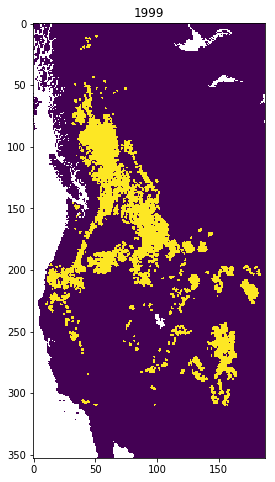

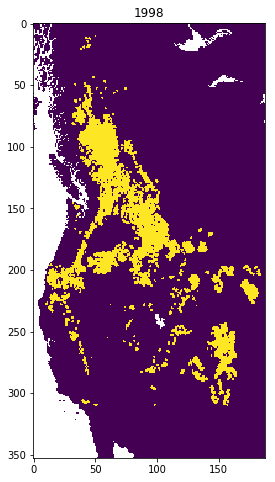

In [32]:
plt.figure();
imshow(np.rot90(m_1999));
plt.title('1999');
plt.figure();
imshow(np.rot90(m_1998));
plt.title('1998');

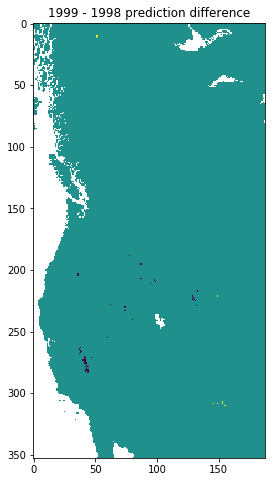

In [33]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');

In [35]:
m_1999 = util.column2matrix(hist_merge, 'probs_1999')
m_1998 = util.column2matrix(hist_merge, 'probs_1998')

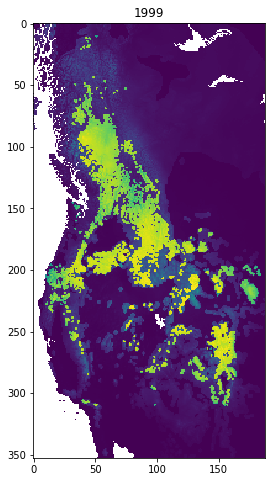

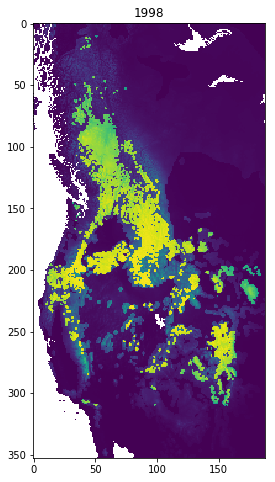

In [36]:
plt.figure();
imshow(np.rot90(m_1999));
plt.title('1999');
plt.figure();
imshow(np.rot90(m_1998));
plt.title('1998');

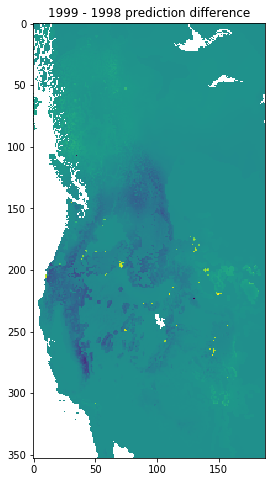

In [37]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');

### Use Prediction Probability in place of Presence/Absence

In [59]:
historic_years = range(1998, 2000)
year = 1999 # <- !

next_year_data = full.loc[full.year == (year + 1), :]
hist_merge = next_year_data[['x', 'y']]

while year >= historic_years[0]:
    hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
    hist_data = mask_data(hist_data, x_range, y_range, verbose=False)

    print('\nBeginning predictions for', year)
    xy = next_year_data.apply(
        lambda row: str(row['x']) + str(row['y']), axis=1)
    print('  Reducing %d data to study area...' % year)
    extras = find_extra_rows(hist_data, xy)
    hist_data = hist_data.drop(extras, axis=0)
    hist_data = hist_data.rename(
        columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
    if year == historic_years[-1]:
        hist_merge = hist_data[['x', 'y']]
    print('  Ascertaining rows are aligned...')
    assert list(hist_data.x) == list(next_year_data.x)
    assert list(hist_data.y) == list(next_year_data.y)

    hist_data.index = next_year_data.index
    hist_merge.index = hist_data.index
    hist_data['next_year_beetle'] = next_year_data['beetle'] # 
    hist_essentials = pd.DataFrame(hist_data[predictors[0]])
    print('  Keeping essentials...')
    for p in predictors[1:]:
        hist_essentials[p] = hist_data[p]

    hist_essentials = scaler.fit_transform(hist_essentials)
    #hist_data['beetle'] = logistic_clf.predict(hist_essentials)
    probs = logistic_clf.predict_proba(hist_essentials)
    probs = [prob[1] for prob in probs]
    hist_data['beetle'] = probs
    print('  Predicting...')
    hist_merge.loc[:, 'probs_%d' % year] = hist_data['beetle']

    preds = logistic_clf.predict(hist_essentials)
    #preds = [prob[1] for prob in probs]
    hist_merge.loc[:, 'preds_%d' % year] = preds

    year -= 1
    next_year_data = hist_data

hist_merge.head()


Beginning predictions for 1999
  Reducing 1999 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Beginning predictions for 1998
  Reducing 1998 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,x,y,probs_1999,preds_1999,probs_1998,preds_1998
0,-1550000.0,-2000000.0,0.003693,0,0.002945,0
1,-1540000.0,-2000000.0,0.003574,0,0.002817,0
2,-1530000.0,-2000000.0,0.003860,0,0.003000,0
3,-1520000.0,-2000000.0,0.005251,0,0.004328,0
4,-1510000.0,-2000000.0,0.005461,0,0.004453,0


In [60]:
m_1999 = util.column2matrix(hist_merge, 'preds_1999')
m_1998 = util.column2matrix(hist_merge, 'preds_1998')

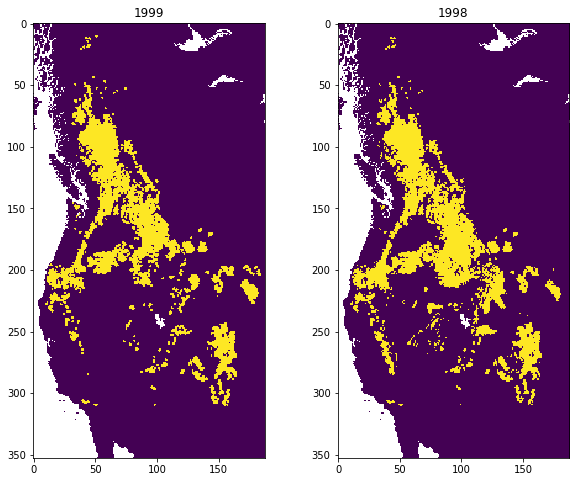

In [65]:
plt.subplot(121);
imshow(np.rot90(m_1999));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(m_1998));
plt.title('1998');

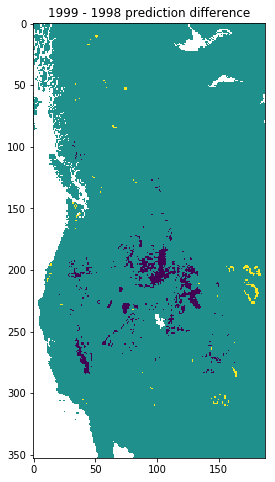

In [66]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');

In [67]:
m_1999 = util.column2matrix(hist_merge, 'probs_1999')
m_1998 = util.column2matrix(hist_merge, 'probs_1998')

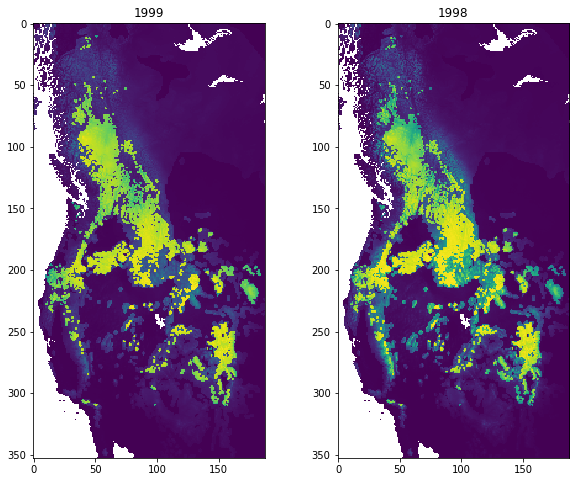

In [68]:
plt.subplot(121);
imshow(np.rot90(m_1999));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(m_1998));
plt.title('1998');

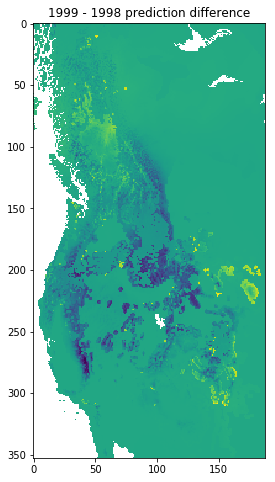

In [69]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');